In [ ]:
import pandas as pd
import ast
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def parse_loose_json(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            yield ast.literal_eval(line)

steam_reviews = list(parse_loose_json('australian_user_reviews.json.gz'))
df = pd.DataFrame(steam_reviews)
print(df.head())

25799


### Break down "reviews" column, seperating into individual rows

Total Reviews in Dataset: 59305

Class Distribution:
recommend
True     52473
False     6832
Name: count, dtype: int64


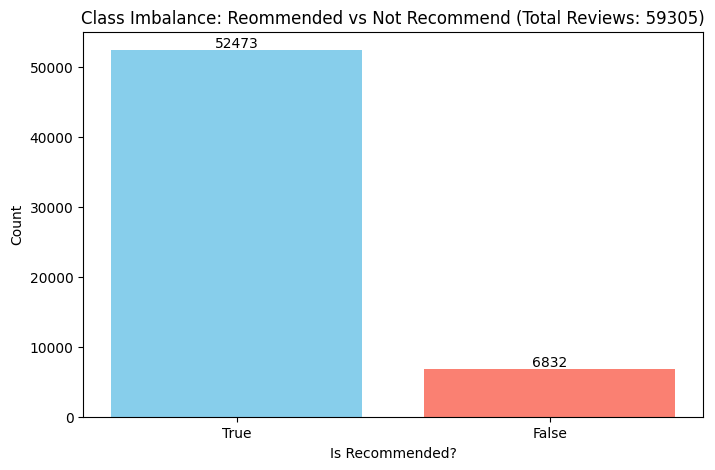

In [ ]:
# Explode and Normalize Reviews: Turns one row with N reviews into N rows with one review each
df_exploded = df.explode('reviews')
df_clean = pd.json_normalize(df_exploded['reviews'].dropna())
total_reviews = len(df_clean)
print(f"Total Reviews in Dataset: {total_reviews}")

# Check Class Imbalance
counts = df_clean['recommend'].value_counts()
print("\nClass Distribution:")
print(counts)

# Visualize Class Distribution
plt.figure(figsize=(8,5))
bars = plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
plt.title(f"Class Imbalance: Reommended vs Not Recommend (Total Reviews: {total_reviews})")
plt.xlabel('Is Recommended?')
plt.ylabel('Count')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

In [15]:
import pprint
pprint.pprint(df_clean.head())

  funny                     posted last_edited item_id  \
0         Posted November 5, 2011.                1250   
1            Posted July 15, 2011.               22200   
2           Posted April 21, 2011.               43110   
3            Posted June 24, 2014.              251610   
4        Posted September 8, 2013.              227300   

                                           helpful  recommend  \
0                                   No ratings yet       True   
1                                   No ratings yet       True   
2                                   No ratings yet       True   
3  15 of 20 people (75%) found this review helpful       True   
4     0 of 1 people (0%) found this review helpful       True   

                                              review  
0  Simple yet with great replayability. In my opi...  
1               It's unique and worth a playthrough.  
2  Great atmosphere. The gunplay can be a bit chu...  
3  I know what you think when you see th

Average number of '!' per review:
recommend
False    0.398419
True     1.014312
Name: exclam_count, dtype: float64


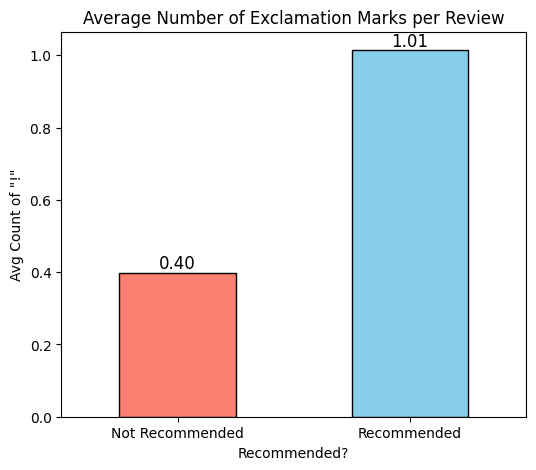

In [16]:
df_clean['exclam_count'] = df_clean['review'].str.count('!').fillna(0)

avg_exclams = df_clean.groupby('recommend')['exclam_count'].mean()

print("Average number of '!' per review:")
print(avg_exclams)

plt.figure(figsize=(6, 5))
colors = ['salmon', 'skyblue']
ax = avg_exclams.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Average Number of Exclamation Marks per Review')
plt.ylabel('Avg Count of "!"')
plt.xlabel('Recommended?')
plt.xticks(ticks=[0, 1], labels=['Not Recommended', 'Recommended'], rotation=0)

# Add label on top
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.show()

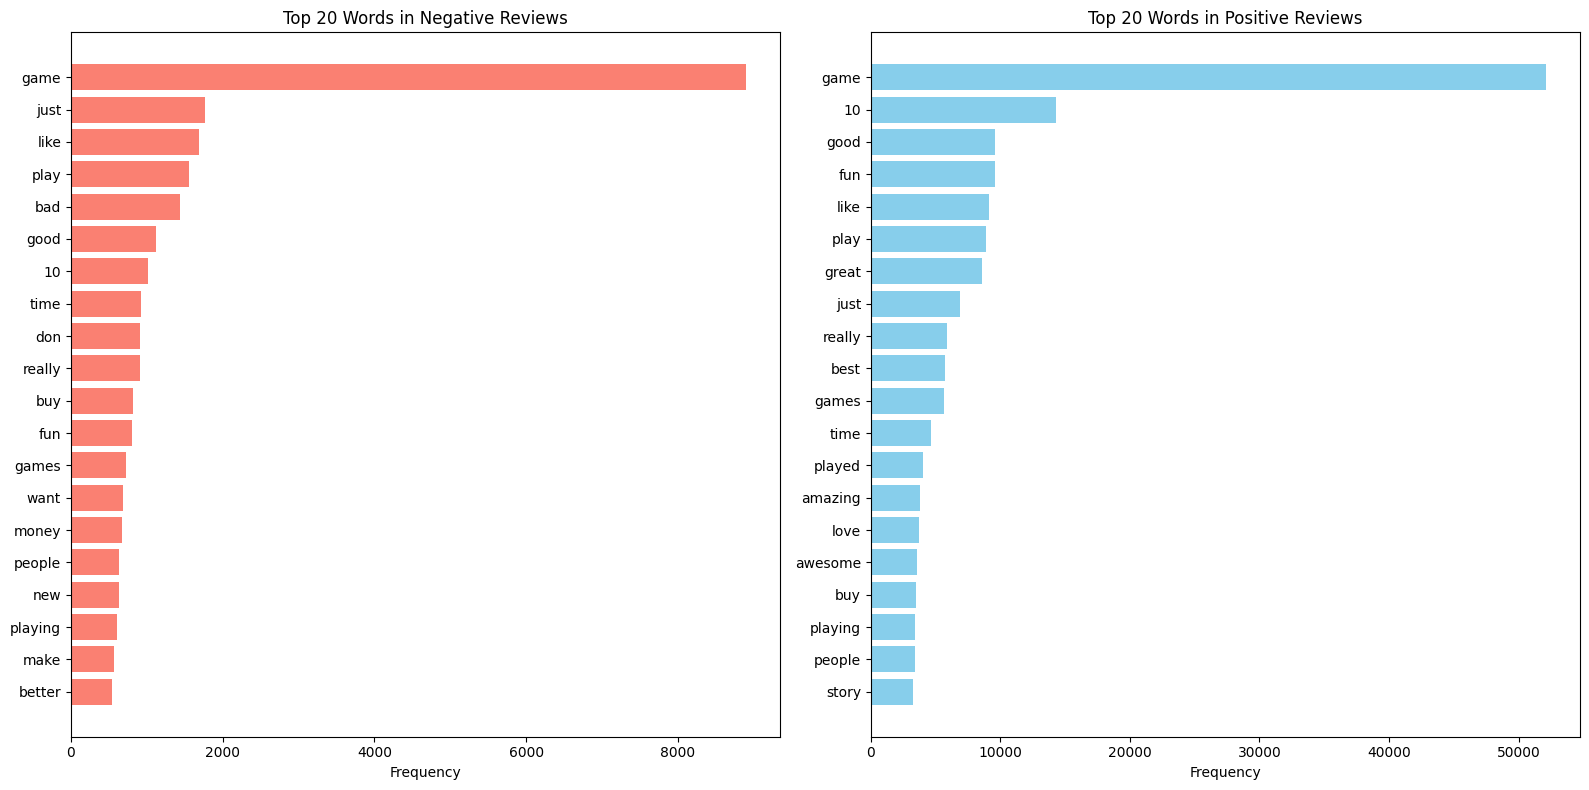

In [ ]:
def plot_top_words(texts, title, color, n=20):
    # removes "the", "a", "in", etc.
    vec = CountVectorizer(stop_words='english')

    
    bag_of_words = vec.fit_transform(texts)
        
    sum_words = bag_of_words.sum(axis=0) 
        
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
        
    words, counts = zip(*words_freq)
        
    plt.barh(words, counts, color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis() 

plt.figure(figsize=(16, 8))

# Plot Not Recommended 
plt.subplot(1, 2, 1) 
neg_reviews = df_clean[df_clean['recommend'] == False]['review'].astype(str)
plot_top_words(neg_reviews, 'Top 20 Words in Negative Reviews', 'salmon')

# Plot Recommended 
plt.subplot(1, 2, 2) 
pos_reviews = df_clean[df_clean['recommend'] == True]['review'].astype(str)
plot_top_words(pos_reviews, 'Top 20 Words in Positive Reviews', 'skyblue')

plt.tight_layout()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X = df_clean.drop('recommend', axis=1)
y = df_clean['recommend']

# Split into Train, Val, Test (70/15/15)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

train_df = pd.concat([X_train_raw, y_train_raw], axis=1)

majority_class = train_df[train_df['recommend'] == True]
minority_class = train_df[train_df['recommend'] == False]

# Randomly sample the majority class to match the minority count without replacement
majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)

train_balanced = pd.concat([majority_downsampled, minority_class])

# Shuffle so model doesn't learn order
train_balanced = shuffle(train_balanced, random_state=42)

X_train_bal = train_balanced.drop('recommend', axis=1)
y_train_bal = train_balanced['recommend']

print("--- Data Shapes ---")
print(f"Original Train size: {len(X_train_raw)}")
print(f"Balanced Train size: {len(X_train_bal)} ")
print(f"Validation size:     {len(X_val)}")
print(f"Test size:           {len(X_test)}")

print("\n--- Class Ratios (Percentage of 'True' labels) ---")
print(f"Original Dataset:  {y.mean():.2%}")
print(f"Balanced Train:    {y_train_bal.mean():.2%}")
print(f"Validation Set:    {y_val.mean():.2%}")
print(f"Test Set:          {y_test.mean():.2%}")

--- Data Shapes ---
Original Train size: 41513
Balanced Train size: 9564 
Validation size:     8896
Test size:           8896

--- Class Ratios (Percentage of 'True' labels) ---
Original Dataset:  88.48%
Balanced Train:    50.00%
Validation Set:    88.48%
Test Set:          88.48%


### Evaluation Metrics Definition

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    
    print(f"---Results for {model_name}---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"TNR (True Neg Rate): {tnr:.4f}")
    print(f"FPR (False Pos Rate): {fpr:.4f}")
    print("-" * 30)

In [ ]:
def run_standard_baseline(X_test, y_test):
    y_pred = [True] * len(y_test)
    evaluate_model(y_test, y_pred, "Standard Baseline (Always True)")

def run_popularity_baseline(X_train_raw, X_test):
    # Count game occurrences in TRAINING set only to avoid leakage
    game_counts = X_train_raw['item_id'].value_counts()
    
    # Take top N games where N is half the total number of unique games
    num_games = len(game_counts)
    top_n = int(num_games * 0.5)
    
    popular_games = set(game_counts.index[:top_n])
    
    # If game is in popular list -> True, else -> False
    y_pred = X_test['item_id'].apply(lambda x: True if x in popular_games else False)
    
    return y_pred

def run_keyword_baseline(X_test):
    # Keywords based on EDA + intuition
    pos_words = ['good', 'fun', 'great', 'best', 'love', 'amazing']
    neg_words = ['bad', 'unfun', 'boring', 'broken', 'refund', 'trash']
    
    predictions = []
    
    for text in X_test['review']:
        text_lower = str(text).lower()
        
        pos_count = sum(word in text_lower for word in pos_words)
        neg_count = sum(word in text_lower for word in neg_words)
        
        # If more positive words, Recommend. Tie or neither defaults to True
        if neg_count > pos_count:
            predictions.append(False)
        else:
            predictions.append(True)
            
    return predictions

In [ ]:
# Naive Guess, Always True Baseline
run_standard_baseline(X_test, y_test)

# Popularity Baseline
y_pred_pop = run_popularity_baseline(X_train_raw, X_test)
evaluate_model(y_test, y_pred_pop, "Popularity Baseline")

# Keyword Baseline
y_pred_kw = run_keyword_baseline(X_test)
evaluate_model(y_test, y_pred_kw, "Keyword Baseline")

---Results for Standard Baseline (Always True)---
Accuracy:  0.8848
Recall:    1.0000
Precision: 0.8848
TNR (True Neg Rate): 0.0000
FPR (False Pos Rate): 1.0000
------------------------------
---Results for Popularity Baseline---
Accuracy:  0.8455
Recall:    0.9405
Precision: 0.8910
TNR (True Neg Rate): 0.1161
FPR (False Pos Rate): 0.8839
------------------------------
---Results for Keyword Baseline---
Accuracy:  0.8868
Recall:    0.9889
Precision: 0.8943
TNR (True Neg Rate): 0.1024
FPR (False Pos Rate): 0.8976
------------------------------


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Setup TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=20000, 
    max_df=0.7, 
    ngram_range=(1, 2),
    stop_words='english' 
)

# Transform Text Data
print("Vectorizing data... (this might take a moment)")
X_train_tfidf = tfidf.fit_transform(X_train_bal['review'].astype(str))
X_test_tfidf = tfidf.transform(X_test['review'].astype(str))

# Setup Logistic Regression Model
log_reg = LogisticRegression(C=0.5, solver='liblinear', random_state=42)

# Train Model on Balanced Data
print("Training Logistic Regression...")
log_reg.fit(X_train_tfidf, y_train_bal)

# Predict on Test Set Imbalanced "Real World" Data
print("Predicting on Test Set...")
y_pred_ml = log_reg.predict(X_test_tfidf)

def evaluate_ml_model(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    recall = tp / (tp + fn)       # TPR
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    tnr = tn / (tn + fp)          # True Negative Rate
    fpr = fp / (fp + tn)          # False Positive Rate
    
    print(f"---Results for {model_name}---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"TNR (True Neg Rate): {tnr:.4f}")
    print(f"FPR (False Pos Rate): {fpr:.4f}")
    print("-" * 30)

evaluate_ml_model(y_test, y_pred_ml, "TF-IDF + Logistic Regression (Balanced Train)")

Vectorizing data... (this might take a moment)
Training Logistic Regression...
Predicting on Test Set...
---Results for TF-IDF + Logistic Regression (Balanced Train)---
Accuracy:  0.7601
Recall:    0.7460
Precision: 0.9775
TNR (True Neg Rate): 0.8683
FPR (False Pos Rate): 0.1317
------------------------------


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create Pipeline (Vectorizer + Model)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Define grid of parameters to test
param_grid = {
    'tfidf__max_features': [10000, 20000, 30000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams vs Bigrams
    'clf__C': [0.1, 0.5, 1.0, 5.0]           # Regularization strength
}

# Optimize for 'accuracy' 
print("Starting Grid Search...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_bal['review'].astype(str), y_train_bal)

print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test['review'].astype(str))

evaluate_ml_model(y_test, y_pred_best, "Tuned Best Model")

Starting Grid Search (this may take 1-2 minutes)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'clf__C': 1.0, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1)}
---Results for Tuned Best Model---
Accuracy:  0.8047
Recall:    0.8059
Precision: 0.9681
TNR (True Neg Rate): 0.7961
FPR (False Pos Rate): 0.2039
------------------------------


In [ ]:
# 1. Create a DataFrame of Test data with Preds
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred_best
results_df['Review_Text'] = X_test['review'] # Ensure text is attached

# Filter for False Positives (Actually Negative, Predicted Positive)
fp_examples = results_df[(results_df['Actual'] == False) & (results_df['Predicted'] == True)]

# Filter for False Negatives (Actually Positive, Predicted Negative)
fn_examples = results_df[(results_df['Actual'] == True) & (results_df['Predicted'] == False)]

# Print some examples
print("--- FALSE POSITIVES (Model thought it was Good, but it was Bad) ---")
for i, row in fp_examples.head(3).iterrows():
    print(f"REVIEW: {row['Review_Text'][:200]}...")
    print("-" * 20)

print("\n--- FALSE NEGATIVES (Model thought it was Bad, but it was Good) ---")
for i, row in fn_examples.head(3).iterrows():
    print(f"REVIEW: {row['Review_Text'][:200]}...")
    print("-" * 20)

--- FALSE POSITIVES (Model thought it was Good, but it was Bad) ---
REVIEW: Gimme an epic upvote if this game and Starbound taught you to never buy early access again....
--------------------
REVIEW: OmG JUmp SCARes So sPOoKY wow YOU SURe dID GEt ME freDDY lOl THIS GAme is SO so SOOO ScaRY CHecK OuT MY FOXY x CHIKA fAN FIC HAHAHAHA thANKS gUYs <3 :3 ~~~~...
--------------------
REVIEW: honestly. really good...
--------------------

--- FALSE NEGATIVES (Model thought it was Bad, but it was Good) ---
REVIEW: totaly bad ♥♥♥...
--------------------
REVIEW: Many glitches in current game but should be fine after awhile...
--------------------
REVIEW: Great game, excellent spiritual successor to Ragnarok. Most problems such as lag and the trading system will be ironed out. A lot of these issues are the creators attempting to fight gold farmers. It ...
--------------------


In [ ]:
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare Data Class for BERT
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load full BERT Tokenizer 
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Convert True/False to 1/0
train_labels = y_train_bal.astype(int).tolist()
test_labels = y_test.astype(int).tolist()

train_texts = X_train_bal['review'].astype(str).tolist()
test_texts = X_test['review'].astype(str).tolist()

# Tokenization
print("Tokenizing data...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    # Calculate standard metrics
    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred)
    recall = recall_score(labels, pred) # TPR

    # Calculate TNR (Specificity) and FPR
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'tnr': tnr,
        'fpr': fpr
    }

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

# 7. Training Arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",     # Evaluate at end of every epoch (2 total)
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 9. Train and Evaluate
print("Starting Training...")
trainer.train()

print("\n--- Final Evaluation on Test Set ---")
final_metrics = trainer.evaluate()

In [ ]:
# Print final metrics
pprint.pprint(final_metrics)

In [ ]:
from sklearn.metrics import confusion_matrix

# Get raw predictions from the trainer
print("Generating predictions for Confusion Matrix...")
raw_pred, _, _ = trainer.predict(test_dataset)

# Convert logits to class labels (0 or 1)
y_pred_bert = np.argmax(raw_pred, axis=1)
y_true_bert = np.array(test_labels) 

# Compute Confusion Matrix
cm = confusion_matrix(y_true_bert, y_pred_bert)

# Plot Confusion Matrix
class_names = ['Not Recommended (0)', 'Recommended (1)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14}) 

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'BERT Confusion Matrix\n(TNR: {final_metrics["eval_tnr"]:.1%})', fontsize=14)
plt.show()